## 2 Data Understanding
### 2.3.1 Preparation before exploring data


In [54]:
# !python install imbalanced-learn
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pandas as pd
from pyspark.sql import *
spark = SparkSession.builder.appName('Data_Understanding').getOrCreate()
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, IntegerType

#### 1.read data from datasource

In [55]:
pandasDF = pd.read_csv('/home/ubuntu/BDAS_yang124/Datasets/College.csv')
sparkDF = spark.createDataFrame(pandasDF)

#### View the data as a whole

In [56]:
sparkDF.printSchema()
sparkDF.show(8)
sparkDF.columns

root
 |-- CN: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F.Undergrad: long (nullable = true)
 |-- P.Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room.Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S.F.Ratio: double (nullable = true)
 |-- perc.alumni: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad.Rate: long (nullable = true)

+--------------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|                  CN|Private|Apps|Accept|Enroll|Top10perc|Top25perc|F.Undergrad|P.Undergrad|Ou

['CN',
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F.Undergrad',
 'P.Undergrad',
 'Outstate',
 'Room.Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S.F.Ratio',
 'perc.alumni',
 'Expend',
 'Grad.Rate']

#### 1.The CN field is removed because it does not have an analysis characteristic

In [57]:
remove_cn_DF = sparkDF.selectExpr(
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 "`F.Undergrad` as F_Undergrad",
 "`P.Undergrad` as P_Undergrad",
 'Outstate',
 "`Room.Board` as Room_Board",
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 "`S.F.Ratio` as S_F_Ratio",
 "`perc.alumni` as perc_alumni",
 'Expend',
"`Grad.Rate` as Grad_Rate" )
pandas_cols=[
    'CN',
    'Private',
    'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate']
pandasDF.columns = pandas_cols


In [58]:
remove_cn_DF.printSchema()
remove_cn_DF.describe().show()
remove_cn_DF.show(8)
remove_cn_DF.columns

root
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F_Undergrad: long (nullable = true)
 |-- P_Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room_Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad_Rate: long (nullable = true)

+-------+-------+------------------+------------------+----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------

['Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate']

#### 2.Remove elements with empty Private field

In [59]:
remove_Null_Private_DF = remove_cn_DF.filter('Private is not null')
remove_Null_Private_DF.printSchema()
remove_Null_Private_DF.describe().show()

root
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F_Undergrad: long (nullable = true)
 |-- P_Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room_Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad_Rate: long (nullable = true)

+-------+-------+------------------+------------------+----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------

#### Transform “Private” type to int

In [60]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
inputCols=['Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
output = assembler.transform(remove_Null_Private_DF)
indexer = StringIndexer(inputCol="Private", outputCol="PrivateIndex")
privateIndex_fixed_DF = indexer.fit(output).transform(output)
privateIndex_fixed_DF.show(8)

+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+--------------------+------------+
|Private|Apps|Accept|Enroll|Top10perc|Top25perc|F_Undergrad|P_Undergrad|Outstate|Room_Board|Books|Personal|PhD|Terminal|S_F_Ratio|perc_alumni|Expend|Grad_Rate|            features|PrivateIndex|
+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+--------------------+------------+
|    Yes|1660|  1232|   721|       23|       52|       2885|        537|    7440|      3300|  450|    2200| 70|      78|     18.1|         12|  7041|       60|[1660.0,1232.0,72...|         0.0|
|    Yes|2186|  1924|   512|       16|       29|       2683|       1227|   12280|      6450|  750|    1500| 29|      30|     12.2|         16| 10527|       56|[2186.0,1924.0,51...|         0.0|
|    Yes|1428|  1097|   336|  

 ### 2.3.2 check data
 #### 1.check data balance

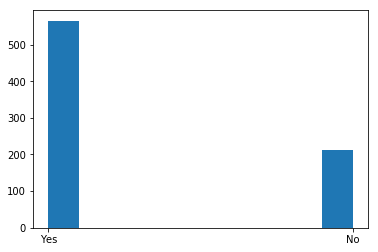

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

publ = np.array(privateIndex_fixed_DF.select('Private').collect())
plt.hist(publ)
plt.show()

#### Data is oversampled based on the PrivateIndex field

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


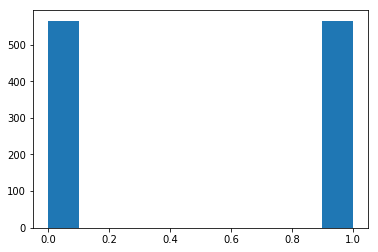

+------+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+----+--------+---------+-----------+-------+---------+------------+--------------------+
|  Apps|Accept|Enroll|Top10perc|Top25perc|F_Undergrad|P_Undergrad|Outstate|Room_Board|Books|Personal| PhD|Terminal|S_F_Ratio|perc_alumni| Expend|Grad_Rate|PrivateIndex|            features|
+------+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+----+--------+---------+-----------+-------+---------+------------+--------------------+
|1660.0|1232.0| 721.0|     23.0|     52.0|     2885.0|      537.0|  7440.0|    3300.0|450.0|  2200.0|70.0|    78.0|     18.1|       12.0| 7041.0|     60.0|         0.0|[1660.0,1232.0,72...|
|2186.0|1924.0| 512.0|     16.0|     29.0|     2683.0|     1227.0| 12280.0|    6450.0|750.0|  1500.0|29.0|    30.0|     12.2|       16.0|10527.0|     56.0|         0.0|[2186.0,1924.0,51...|
|1428.0|1097.0| 336.0|     22.0|     50.0|     103

In [62]:
import pandas 
from imblearn.over_sampling import SMOTE
data=privateIndex_fixed_DF.drop('Private','features').toPandas()
smo = SMOTE(random_state=42)
columns = data.columns
pridata=privateIndex_fixed_DF.select('PrivateIndex').toPandas()
X_smo, y_smo = smo.fit_sample(data, pridata)
x_smote_resampled = pandas.DataFrame(X_smo,columns=columns)
publ = np.array(x_smote_resampled['PrivateIndex'])
plt.hist(publ)
plt.show()

privateIndex_fixed_DF = spark.createDataFrame(x_smote_resampled)

assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
privateIndex_fixed_DF = assembler.transform(privateIndex_fixed_DF)
privateIndex_fixed_DF.show(8)


#### split data by random

In [63]:
final_data = privateIndex_fixed_DF.select("features",'PrivateIndex')
train_data,test_data = final_data.randomSplit([0.7,0.3])

#### 2.check data importances

 1) Outstate                       0.249252
 2) F_Undergrad                    0.162155
 3) P_Undergrad                    0.135462
 4) Accept                         0.087868
 5) Room_Board                     0.066108
 6) Enroll                         0.065237
 7) Apps                           0.058135
 8) S_F_Ratio                      0.048731
 9) Expend                         0.044648
10) perc_alumni                    0.028878
11) PhD                            0.016344
12) Grad_Rate                      0.010580
13) Personal                       0.008221
14) Terminal                       0.007292
15) Top10perc                      0.005926
16) Top25perc                      0.002693
17) Books                          0.002470


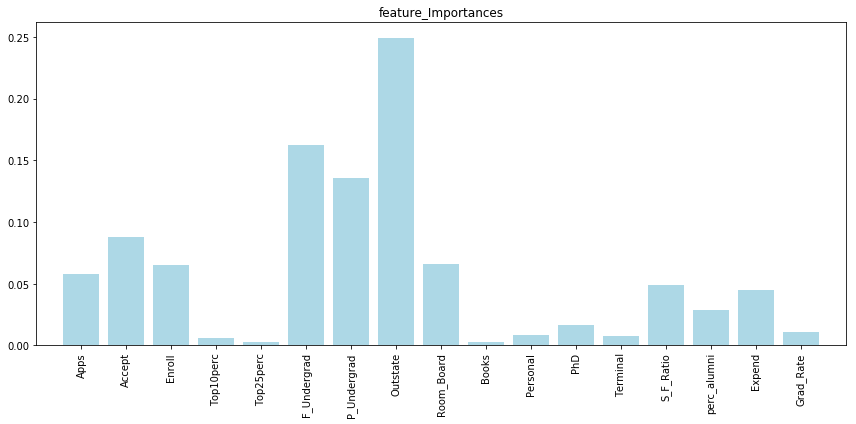

In [64]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol='PrivateIndex',featuresCol='features')
rfc_model = rfc.fit(train_data)
feature_Importances=rfc_model.featureImportances
sort_index=np.argsort(feature_Importances)[::-1]

sort_index=sort_index.tolist()
for f in sort_index:
    print("%2d) %-*s %f" % (sort_index.index(f)+1,30,inputCols[f],feature_Importances[f]))
plt.figure(figsize=(12,6))
plt.title("feature_Importances")
plt.bar(inputCols,
       feature_Importances,
        color="lightblue",
        align="center"
       )
plt.xticks(range(17),inputCols,rotation='vertical')
plt.xlim([-1,17])
plt.tight_layout()
plt.show()

#### 3.fields skewness check

             rows classCnt mostClassCnt mostClassRio
Apps         1130        4         1057     0.935398
Accept       1130        4         1029     0.910619
Enroll       1130        4          889     0.786726
Top10perc    1130        4          655     0.579646
Top25perc    1130        4          117      0.10354
F_Undergrad  1130        4          878     0.776991
P_Undergrad  1130        4         1103     0.976106
Outstate     1130        4          404     0.357522
Room_Board   1130        4          262     0.231858
Books        1130        4          974     0.861947
Personal     1130        4          863     0.763717
PhD          1130        4           11   0.00973451
Terminal     1130        4           16    0.0141593
S_F_Ratio    1130        4          243     0.215044
perc_alumni  1130        4          513     0.453982
Expend       1130        4         1077     0.953097
Grad_Rate    1130        4           62    0.0548673


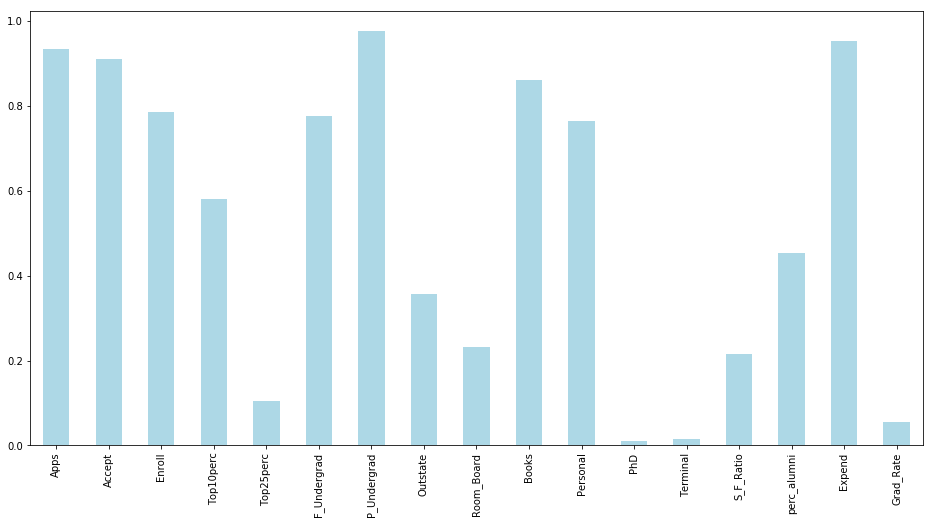

In [65]:

new_DF = privateIndex_fixed_DF.drop('features','PrivateIndex').toPandas()
new_df2 = new_DF[pandas_cols[2:len(pandas_cols)]]

skewDf2 = pd.DataFrame(index=new_DF.columns.values,columns=['rows','classCnt','mostClassCnt','mostClassRio'])
m2,n2 = new_df2.shape
for j in range(n2):
    ser = new_df2.iloc[:,j]
    name = new_df2.columns[j]
    freqSer = pd.value_counts(pd.cut(ser,4))
    skewDf2.loc[name,'rows'] = m2
    skewDf2.loc[name,'classCnt'] = len(freqSer)
    skewDf2.loc[name,'mostClassCnt'] = freqSer[0] 
    skewDf2.loc[name,'mostClassRio'] = freqSer[0] * 1.00 / m2
skewDf = pd.concat([skewDf2],axis=0)
print(skewDf)
skewDf_mostClassRio=skewDf['mostClassRio']
skewDf_mostClassRio.plot(kind='bar',figsize=(16,8), color='lightblue')

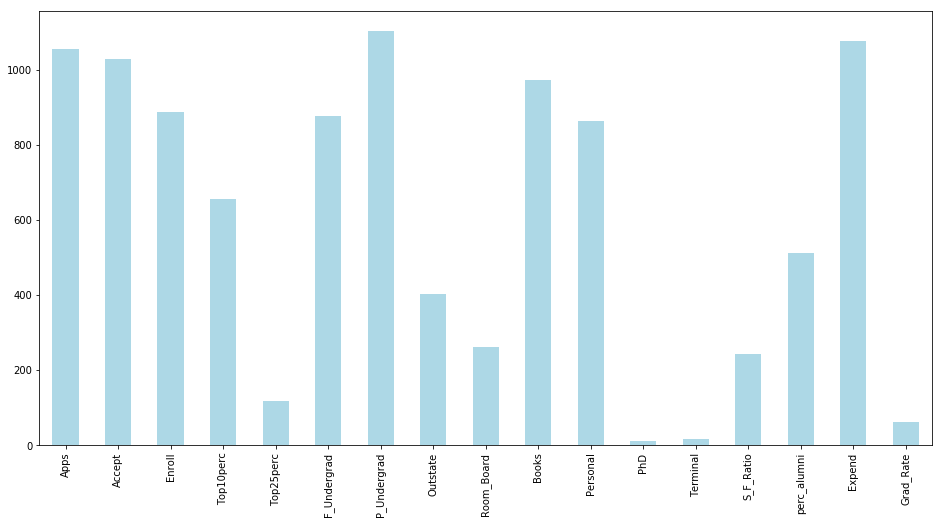

In [66]:
skewDf_mostClassCnt=skewDf['mostClassCnt']
skewDf_mostClassCnt.plot(kind='bar',figsize=(16,8), color='lightblue')

### 2.4Verify The Data Quality
#### 1.verify data null value

             rows  nullCnt
Apps         1130        0
Accept       1130        0
Enroll       1130        0
Top10perc    1130        0
Top25perc    1130        0
F_Undergrad  1130        0
P_Undergrad  1130        0
Outstate     1130        0
Room_Board   1130        0
Books        1130        0
Personal     1130        0
PhD          1130        0
Terminal     1130        0
S_F_Ratio    1130        0
perc_alumni  1130        0
Expend       1130        0
Grad_Rate    1130        0


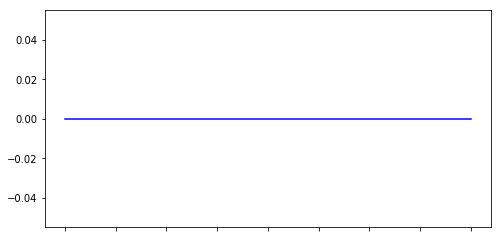

In [67]:
m,n = new_DF.shape
rowsSer = pd.Series(index=new_DF.columns)
rowsSer.name = 'rows'
nullCntSer = new_DF.isnull().sum()
nullCntSer.name = 'nullCnt'
missDf = pd.concat([rowsSer,nullCntSer],axis=1)
missDf['rows'] = m
print(missDf)
missDf['nullCnt'].plot(kind='line',figsize=(8,4),color='blue')

#### 2. verify Field unique number 

             rows  uiqCnt
Apps         1130    1064
Accept       1130    1046
Enroll       1130     934
Top10perc    1130     427
Top25perc    1130     431
F_Undergrad  1130    1067
P_Undergrad  1130     919
Outstate     1130     979
Room_Board   1130     905
Books        1130     433
Personal     1130     643
PhD          1130     408
Terminal     1130     392
S_F_Ratio    1130     522
perc_alumni  1130     394
Expend       1130    1097
Grad_Rate    1130     421


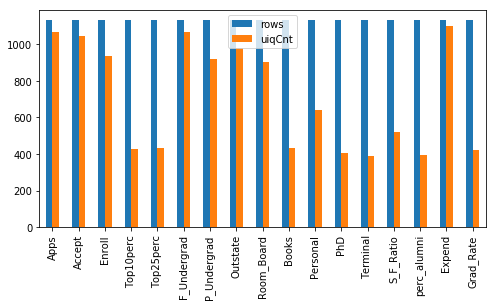

In [68]:
m,n = new_DF.shape
uiqDf = pd.DataFrame(index=new_DF.columns,columns=['rows','uiqCnt'])
uiqDf['rows'] = m
for j in range(n):
    ser = new_DF.iloc[:,j]
    name = new_DF.columns[j]
    uiqCnt = len(ser.unique())
    uiqDf.loc[name, 'uiqCnt'] = uiqCnt
print(uiqDf)
uiqDf.plot(kind='bar',figsize=(8,4))

#### 3.Outlier detection

                 max     min         mean          std       cov  \
Apps         48094.0    81.0  3884.205909  4604.062768  1.185329   
Accept       26330.0    72.0  2643.504630  2944.832953  1.113988   
Enroll        6392.0    35.0  1055.115018  1111.865048  1.053786   
Top10perc       96.0     1.0    25.863699    16.704865  0.645881   
Top25perc      100.0     9.0    54.620460    19.061265  0.348977   
F_Undergrad  31643.0   139.0  5226.378194  5756.989725  1.101526   
P_Undergrad  21836.0     1.0  1149.812260  1639.103606  1.425540   
Outstate     21700.0  2340.0  9297.721346  3868.233929  0.416041   
Room_Board    8124.0  1780.0  4147.451523  1046.119546  0.252232   
Books         2340.0    96.0   547.475359   149.818362  0.273653   
Personal      6800.0   250.0  1434.893752   655.827040  0.457056   
PhD            103.0     8.0    73.872520    14.972466  0.202680   
Terminal       100.0    24.0    80.443329    13.638234  0.169538   
S_F_Ratio       39.8     2.5    15.102174     3.

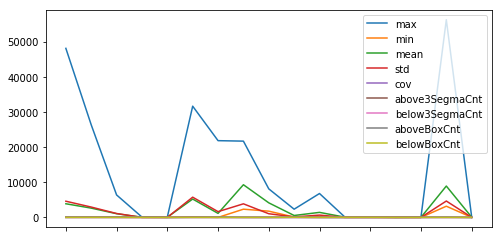

In [69]:

resDf = new_df2.describe()
resDf.loc['cov'] = resDf.loc['std'] / resDf.loc['mean']   
resDf.loc['mean+3std'] = resDf.loc['mean'] + 3 * resDf.loc['std']  
resDf.loc['mean-3std'] = resDf.loc['mean'] - 3 * resDf.loc['std'] 
resDf.loc['75%+1.5dist'] = resDf.loc['75%'] + 1.5 * (resDf.loc['75%'] - resDf.loc['25%'])  
resDf.loc['25%-1.5dist'] = resDf.loc['25%'] - 1.5 * (resDf.loc['75%'] - resDf.loc['25%'])  

segmaSer1 = new_df2[new_df2 > resDf.loc['mean+3std']].count()   
segmaSer1.name = 'above3SegmaCnt'
segmaSer2 = new_df2[new_df2 < resDf.loc['mean-3std']].count()    
segmaSer2.name = 'below3SegmaCnt'

boxSer1 = new_df2[new_df2 > resDf.loc['75%+1.5dist']].count()    
boxSer1.name = 'aboveBoxCnt'
boxSer2 = new_df2[new_df2 < resDf.loc['25%-1.5dist']].count()    
boxSer2.name = 'belowBoxCnt'

outTmpDf1 = pd.concat([segmaSer1,segmaSer2,boxSer1,boxSer2],axis=1)
outTmpDf2 = resDf.loc[['max','min','mean','std','cov']]
outDf = pd.concat([outTmpDf2.T, outTmpDf1], axis=1)
print(outDf)
outDf.plot(kind='line',figsize=(8,4))

#### 4.Normal distribution check

             rows  posCnt  zeroCnt  negCnt
Apps         1130    1130        0       0
Accept       1130    1130        0       0
Enroll       1130    1130        0       0
Top10perc    1130    1130        0       0
Top25perc    1130    1130        0       0
F_Undergrad  1130    1130        0       0
P_Undergrad  1130    1130        0       0
Outstate     1130    1130        0       0
Room_Board   1130    1130        0       0
Books        1130    1130        0       0
Personal     1130    1130        0       0
PhD          1130    1130        0       0
Terminal     1130    1130        0       0
S_F_Ratio    1130    1130        0       0
perc_alumni  1130    1128        2       0
Expend       1130    1130        0       0
Grad_Rate    1130    1130        0       0


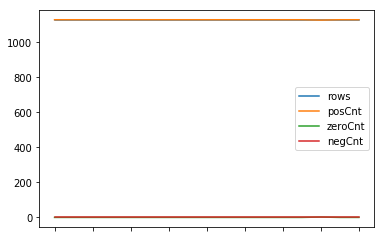

In [70]:

distDf = pd.DataFrame(index=new_DF.columns.values,columns=['rows','posCnt','zeroCnt','negCnt'])
m,n = new_df2.shape
for j in range(n):
    ser = new_df2.iloc[:,j]
    name = new_df2.columns[j]
    posCnt = ser[ser>0].count()
    zeroCnt = ser[ser==0].count()
    negCnt = ser[ser<0].count()
    distDf.loc[name,'rows'] = m
    distDf.loc[name,'posCnt'] = posCnt
    distDf.loc[name,'zeroCnt'] = zeroCnt
    distDf.loc[name, 'negCnt'] = negCnt
print(distDf)
distDf.plot()

#### 5.The normal distribution of the data

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


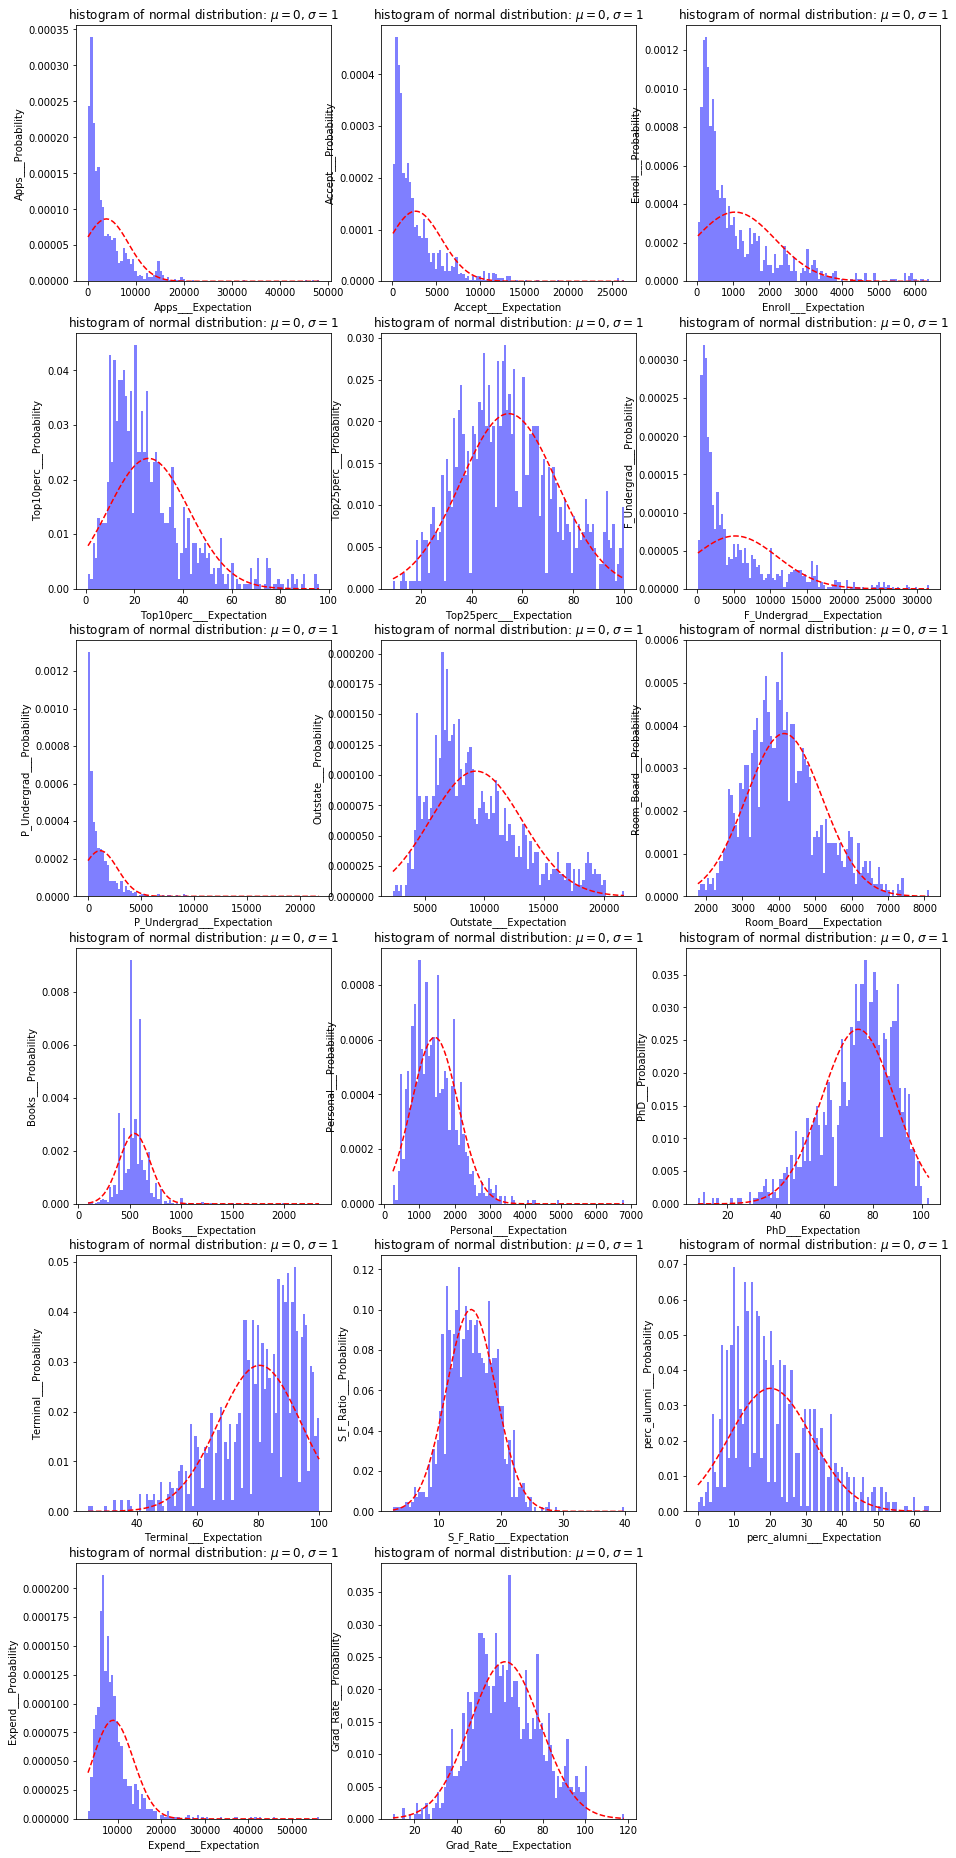

In [71]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def expectation(df):
    plt.figure(figsize=(16,33))
    i=0
    for subpo in df.columns:
        x=df[subpo]
        plt.subplot(6,3,1+i)
        num_bins = 100
        mu = np.mean(x)
        sigma =np.std(x) 
        n, bins, patches = plt.hist(x, num_bins, density=True, facecolor = 'blue', alpha = 0.5)

        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel(subpo +"___"+ 'Expectation')
        plt.ylabel(subpo +"___"+ 'Probability')
        plt.title('histogram of normal distribution: $\mu = 0$, $\sigma=1$')

        plt.subplots_adjust(left = 0.15)
        i+=1
    plt.show()
expectation(new_df2)

#### Distribution of data to private

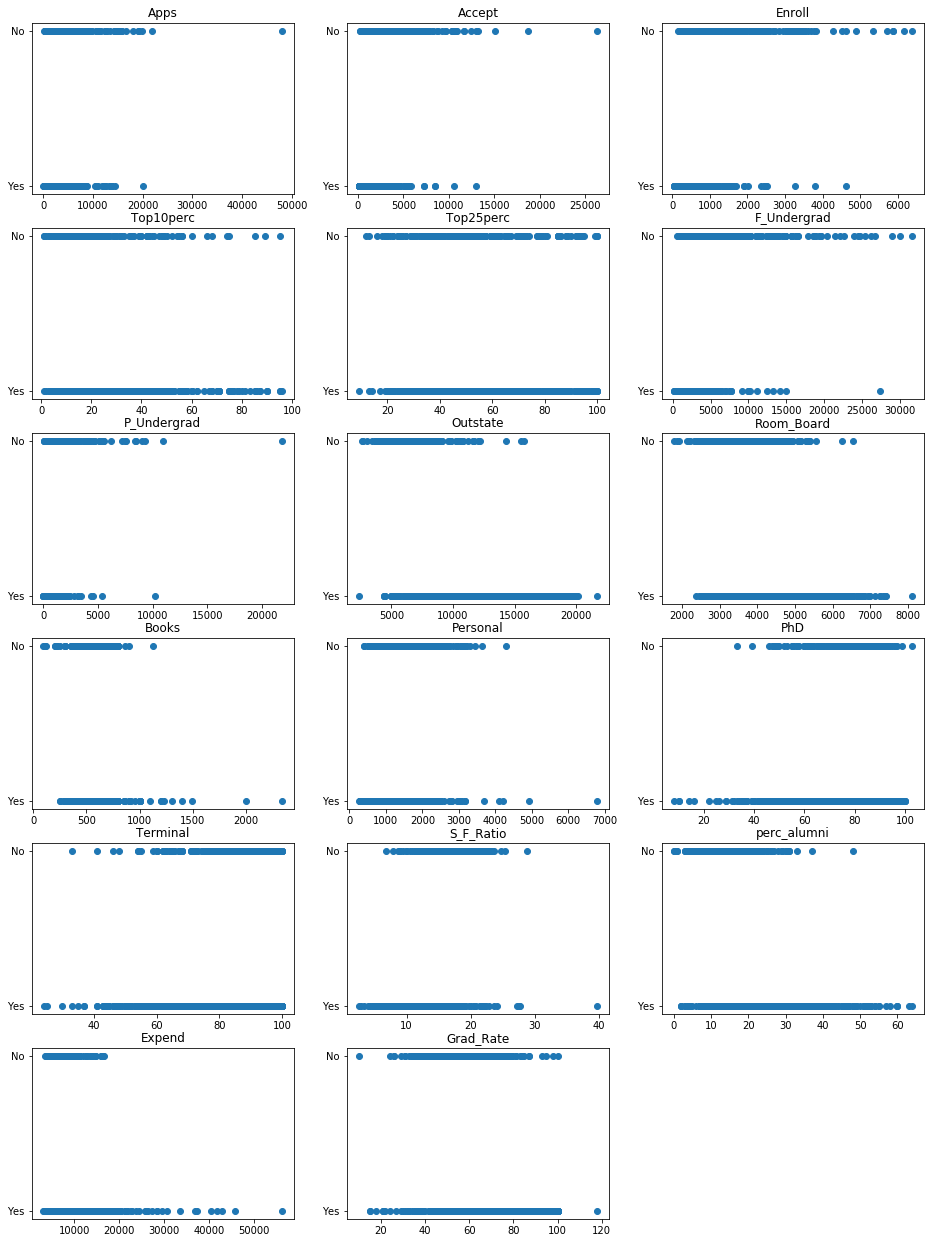

In [72]:
y=pandasDF['Private']
plt.figure(figsize=(16,22))
i=0
for subpo in new_df2.columns:
    x=pandasDF[subpo]
    plt.subplot(6,3,1+i)
    plt.title(subpo)
    plt.scatter(x,y)
    i+=1
plt.show()

## 3 Data preparation

### clean Data

#### 1.Missing value processing of data

In [73]:
remove_Null_Private_DF =  privateIndex_fixed_DF.drop('features').na.drop()

#### 2.Delete non-important fields and rebuild the data

In [74]:
remove_Null_Private_DF =remove_Null_Private_DF.drop( 'PhD','Grad_Rate','Terminal','Books','Personal','Top10perc','Top25perc')


inputCols=['Apps',
 'Accept',
 'Enroll',
 'Expend',          
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'S_F_Ratio',
 'perc_alumni']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
privateIndex_fixed_DF = assembler.transform(remove_Null_Private_DF)

privateIndex_fixed_DF.show(8)


+------+------+------+-----------+-----------+--------+----------+---------+-----------+-------+------------+--------------------+
|  Apps|Accept|Enroll|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio|perc_alumni| Expend|PrivateIndex|            features|
+------+------+------+-----------+-----------+--------+----------+---------+-----------+-------+------------+--------------------+
|1660.0|1232.0| 721.0|     2885.0|      537.0|  7440.0|    3300.0|     18.1|       12.0| 7041.0|         0.0|[1660.0,1232.0,72...|
|2186.0|1924.0| 512.0|     2683.0|     1227.0| 12280.0|    6450.0|     12.2|       16.0|10527.0|         0.0|[2186.0,1924.0,51...|
|1428.0|1097.0| 336.0|     1036.0|       99.0| 11250.0|    3750.0|     12.9|       30.0| 8735.0|         0.0|[1428.0,1097.0,33...|
| 417.0| 349.0| 137.0|      510.0|       63.0| 12960.0|    5450.0|      7.7|       37.0|19016.0|         0.0|[417.0,349.0,137....|
| 193.0| 146.0|  55.0|      249.0|      869.0|  7560.0|    4120.0|     11.9|       

#### Outlier handling

#### Look for normal ranges

In [75]:

cols =['Apps', 'Accept', 'Enroll', 'Expend', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'perc_alumni']
print(cols)
bounds = {}
for col in cols:
    quantiles = remove_Null_Private_DF.approxQuantile(col,[0.05,0.95],0.05)
    IQR = quantiles[1] - quantiles[0]
    if quantiles[0] - 1.5*IQR<0:
        bounds[col] = [
        quantiles[0],
        quantiles[1] + 1.5*IQR
        ]
    else:
        bounds[col] = [
        quantiles[0] - 1.5*IQR,
        quantiles[1] + 1.5*IQR
        ]
print(bounds) 

['Apps', 'Accept', 'Enroll', 'Expend', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'perc_alumni']
{'Enroll': [35.0, 15927.5], 'Outstate': [2340.0, 50740.0], 'Accept': [72.0, 65717.0], 'P_Undergrad': [1.0, 54588.5], 'Expend': [3186.0, 135803.5], 'F_Undergrad': [139.0, 78899.0], 'perc_alumni': [0.0, 160.0], 'Apps': [81.0, 120113.5], 'S_F_Ratio': [2.5, 95.75], 'Room_Board': [1780.0, 17640.0]}


#### Marked outlier

In [76]:
outliers = remove_Null_Private_DF.select([((remove_Null_Private_DF[c] < bounds[c][0]) |(remove_Null_Private_DF[c]>bounds[c][1])).alias(c) for c in cols])
outliers.show(8)

+-----+------+------+------+-----------+-----------+--------+----------+---------+-----------+
| Apps|Accept|Enroll|Expend|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio|perc_alumni|
+-----+------+------+------+-----------+-----------+--------+----------+---------+-----------+
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      false|   false|     false|    false|      false|
|false| false| false| false|      false|      fals

#### Replacement outlier

In [77]:
from pyspark.sql.functions import *

# print(privateIndex_fixed_DF.toPandas().describe())
privateIndex_pandas_DF=privateIndex_fixed_DF.toPandas().describe()

print(cols)
for col in cols:
    privateIndex_fixed_DF = privateIndex_fixed_DF.withColumn(col, 
                when(privateIndex_fixed_DF[col] < bounds[col][0],privateIndex_pandas_DF[col]['mean'])
                .when(privateIndex_fixed_DF[col] > bounds[col][1], privateIndex_pandas_DF[col]['mean'])
                .otherwise(privateIndex_fixed_DF[col] ).alias(col))
    print(col+" done")
privateIndex_fixed_DF.show(8)
print(privateIndex_fixed_DF.toPandas().describe())

['Apps', 'Accept', 'Enroll', 'Expend', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'perc_alumni']
Apps done
Accept done
Enroll done
Expend done
F_Undergrad done
P_Undergrad done
Outstate done
Room_Board done
S_F_Ratio done
perc_alumni done
+------+------+------+-----------+-----------+--------+----------+---------+-----------+-------+------------+--------------------+
|  Apps|Accept|Enroll|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio|perc_alumni| Expend|PrivateIndex|            features|
+------+------+------+-----------+-----------+--------+----------+---------+-----------+-------+------------+--------------------+
|1660.0|1232.0| 721.0|     2885.0|      537.0|  7440.0|    3300.0|     18.1|       12.0| 7041.0|         0.0|[1660.0,1232.0,72...|
|2186.0|1924.0| 512.0|     2683.0|     1227.0| 12280.0|    6450.0|     12.2|       16.0|10527.0|         0.0|[2186.0,1924.0,51...|
|1428.0|1097.0| 336.0|     1036.0|       99.0| 11250.0|    3750.0|     12.9|    

## 4 Data conversion

#### Data LOG projection

In [78]:
d = {}
print('the columns do Log conversion')
print(cols)
print('-'*40)
for col in cols:
      d[col] = privateIndex_fixed_DF.approxQuantile(col,[0.01,0.99],0.25)

for col in cols:
    privateIndex_fixed_DF = privateIndex_fixed_DF.withColumn(col, log(when(privateIndex_fixed_DF[col] < d[col][0],d[col][0]).when(privateIndex_fixed_DF[col] > d[col][1], d[col][1]).otherwise(privateIndex_fixed_DF[col] ) +1).alias(col))
    print(col+" done")

privateIndex_fixed_DF.show(10)

the columns do Log conversion
['Apps', 'Accept', 'Enroll', 'Expend', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'perc_alumni']
----------------------------------------
Apps done
Accept done
Enroll done
Expend done
F_Undergrad done
P_Undergrad done
Outstate done
Room_Board done
S_F_Ratio done
perc_alumni done
+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------+--------------------+
|             Apps|           Accept|            Enroll|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|       perc_alumni|           Expend|PrivateIndex|            features|
+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------+--------------------+
|

#### Distribution of data LOG after projection

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


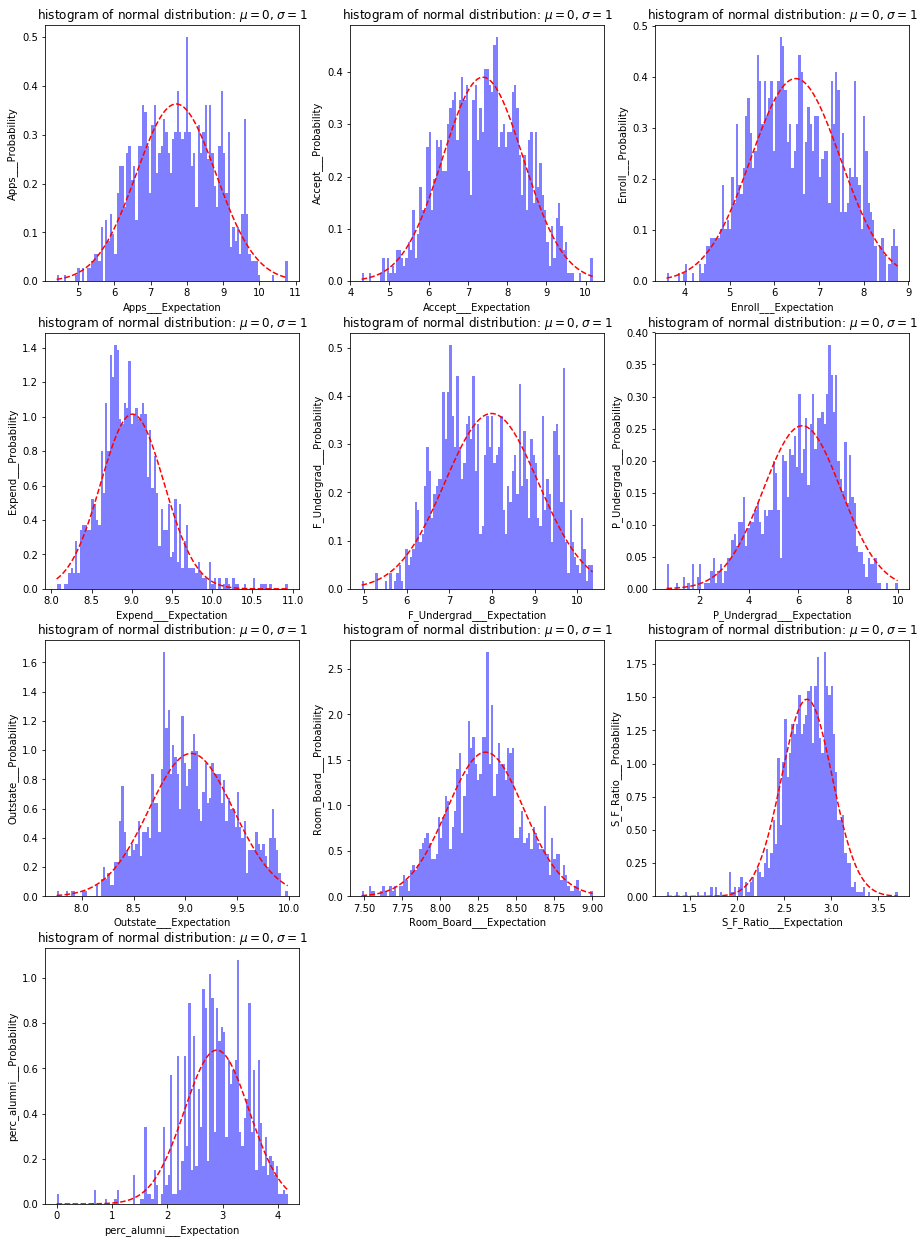

In [79]:
normalizer_df_pd = privateIndex_fixed_DF.select('PrivateIndex','Apps', 'Accept', 'Enroll', 'Expend', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'perc_alumni').toPandas()
expectation_df = normalizer_df_pd.drop('PrivateIndex',axis=1)
expectation(expectation_df)
normalizer_df_pd.to_csv('/home/ubuntu/BDAS_yang124/Datasets/normalizer_df_pandas.csv')